# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import math

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

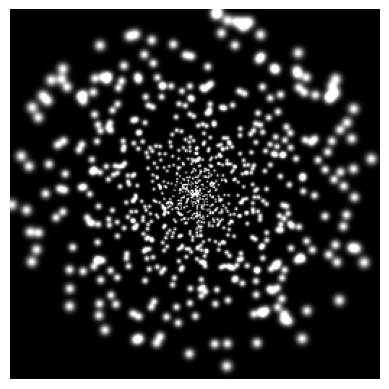

In [3]:
# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [4]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

Iterations:   0%|                                                                                                                                                                                                     | 0/2000 [00:00<?, ?iter/s]

Loss = 0.0020: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.81iter/s]


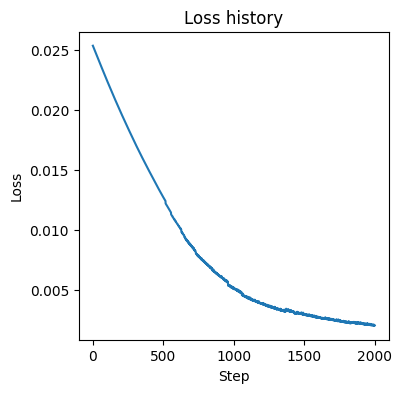

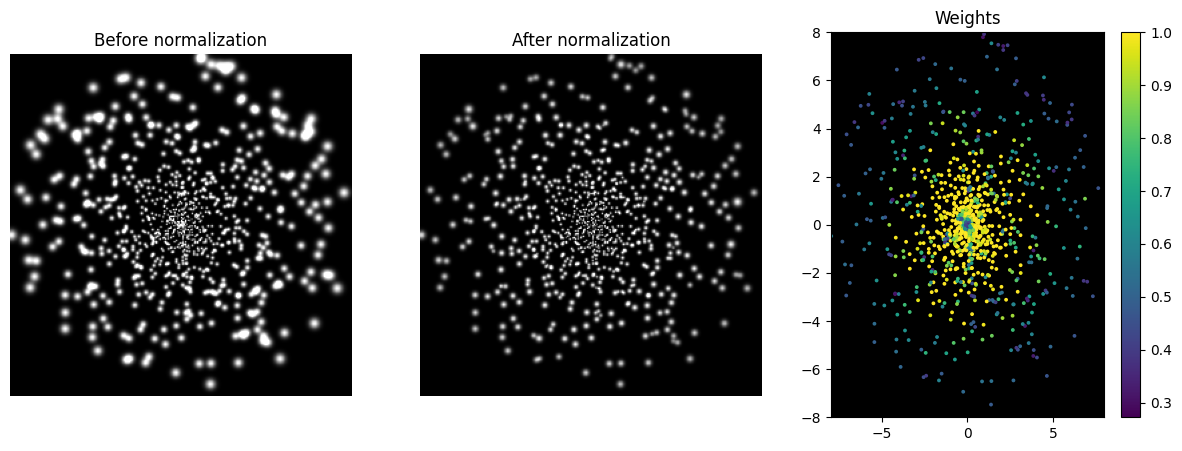

Percentage of amplitude: 77.36%


In [5]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [73]:
from phosphene.density import VisualFieldMapper

In [74]:
mapper = VisualFieldMapper(simulator=simulator)

In [75]:
# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=12, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

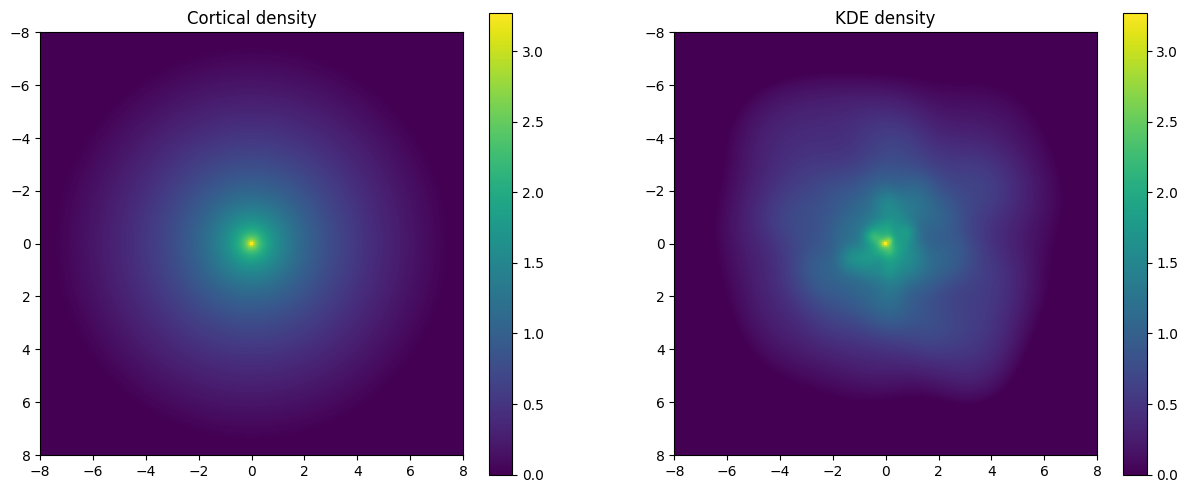

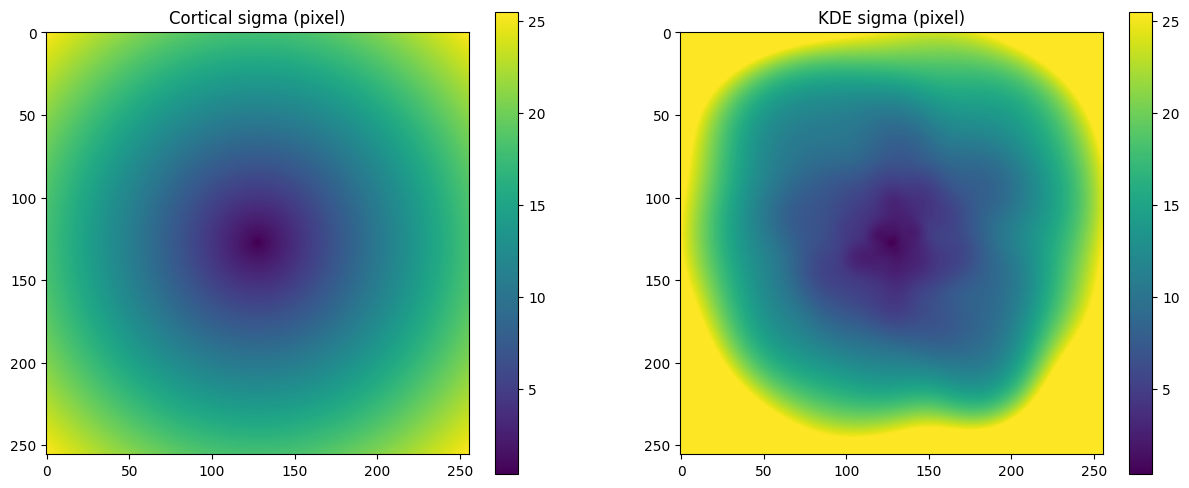

In [76]:
# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Input Modulation

In [77]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_loader = DataLoader(
    ImageFolder('../../data/LaPa_zoomed/', transform=transform),
    batch_size=1,
    shuffle=False
)

In [78]:
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation

In [79]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

UnifiedInputModulation()

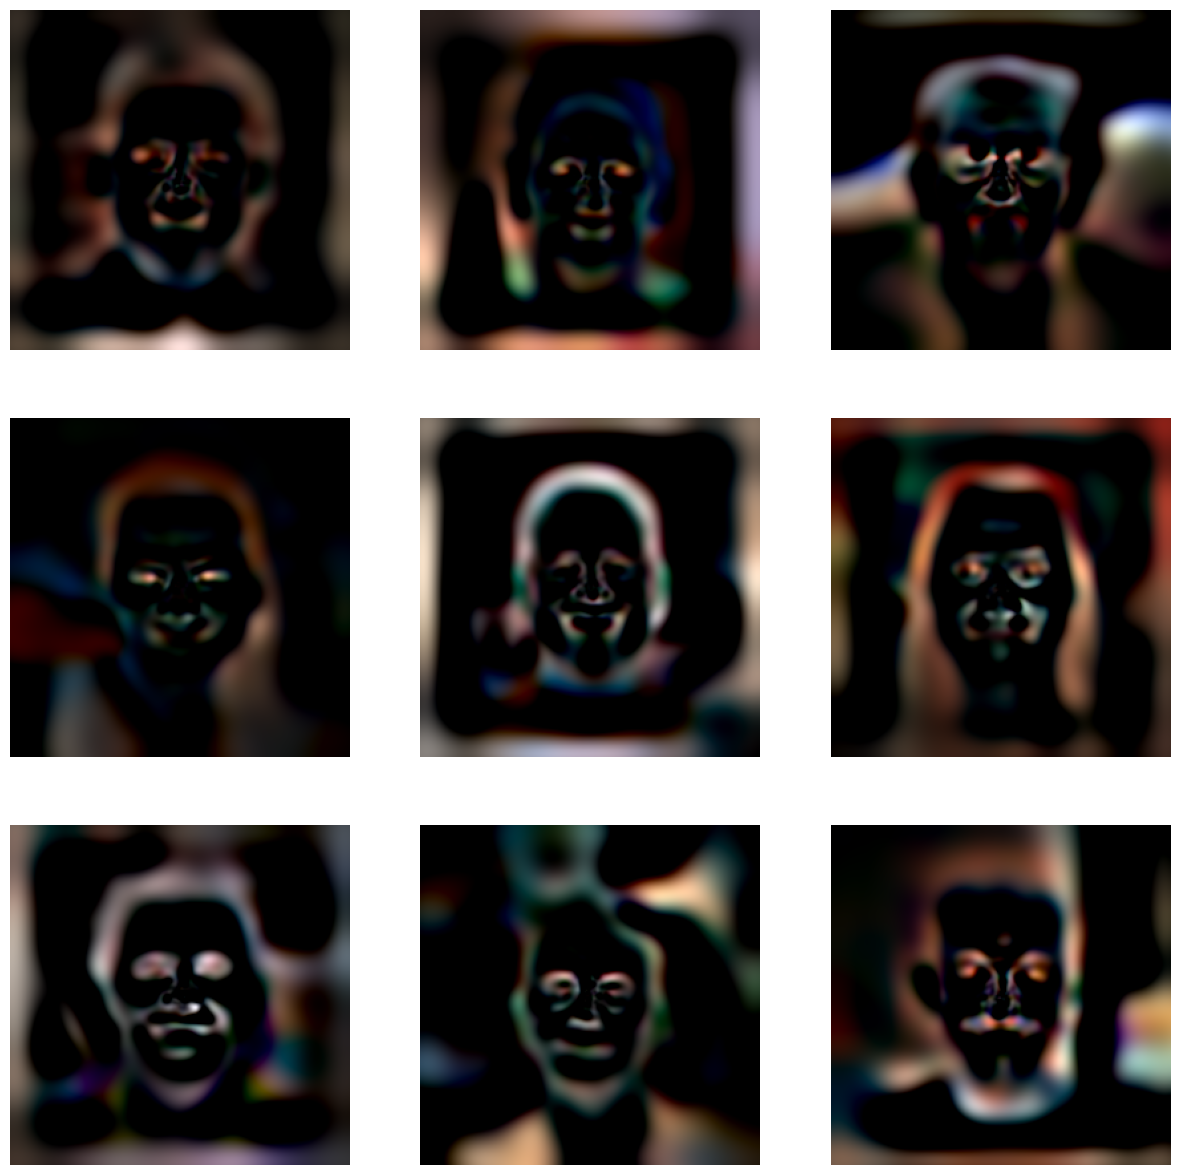

In [80]:
images = []
filtered_images = []

for img, _ in data_loader:
    img = img.cuda().detach()

    with torch.no_grad():
        filtered_img = layer(img).detach().cpu().clip(0, None).numpy()

    # normalize between 0 and 1
    filtered_img = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min())
    
    filtered_images.append(filtered_img)
    images.append(img.cpu())

    # show filtered_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(filtered_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0].transpose(1,2,0), cmap='gray')
    plt.axis('off')

plt.show()

In [81]:
def modified_cdf_normalization(electrode, amplitude):
    # electrode: a tensor of stimulation values.
    # Compute mean and std on the nonzero elements if desired,
    # or use global mean/std if that makes sense in your application.
    # Here, for example, we compute over all values:
    mean_val = electrode.mean()
    std_val = electrode.std()
    
    # Compute the standard normal CDF at a value:
    def standard_normal_cdf(x):
        return 0.5 * (1 + torch.erf(x / math.sqrt(2)))
    
    # Compute CDF at zero:
    cdf0 = standard_normal_cdf((0 - mean_val) / std_val)
    
    # Create a normalized tensor, preserving zeros:
    # For nonzero elements, apply the mapping.
    normalized = electrode.clone()
    # Create a mask for nonzero entries:
    mask = electrode > 0
    # For these entries, compute their z-scores:
    z = (electrode[mask] - mean_val) / std_val
    cdfx = standard_normal_cdf(z)
    
    # Map the nonzero elements so that when x==0, the output is 0,
    # and as x increases, F(x) approaches amplitude.
    normalized[mask] = amplitude * (cdfx - cdf0) / (1 - cdf0)
    # (Elements that are zero remain zero.)
    return normalized

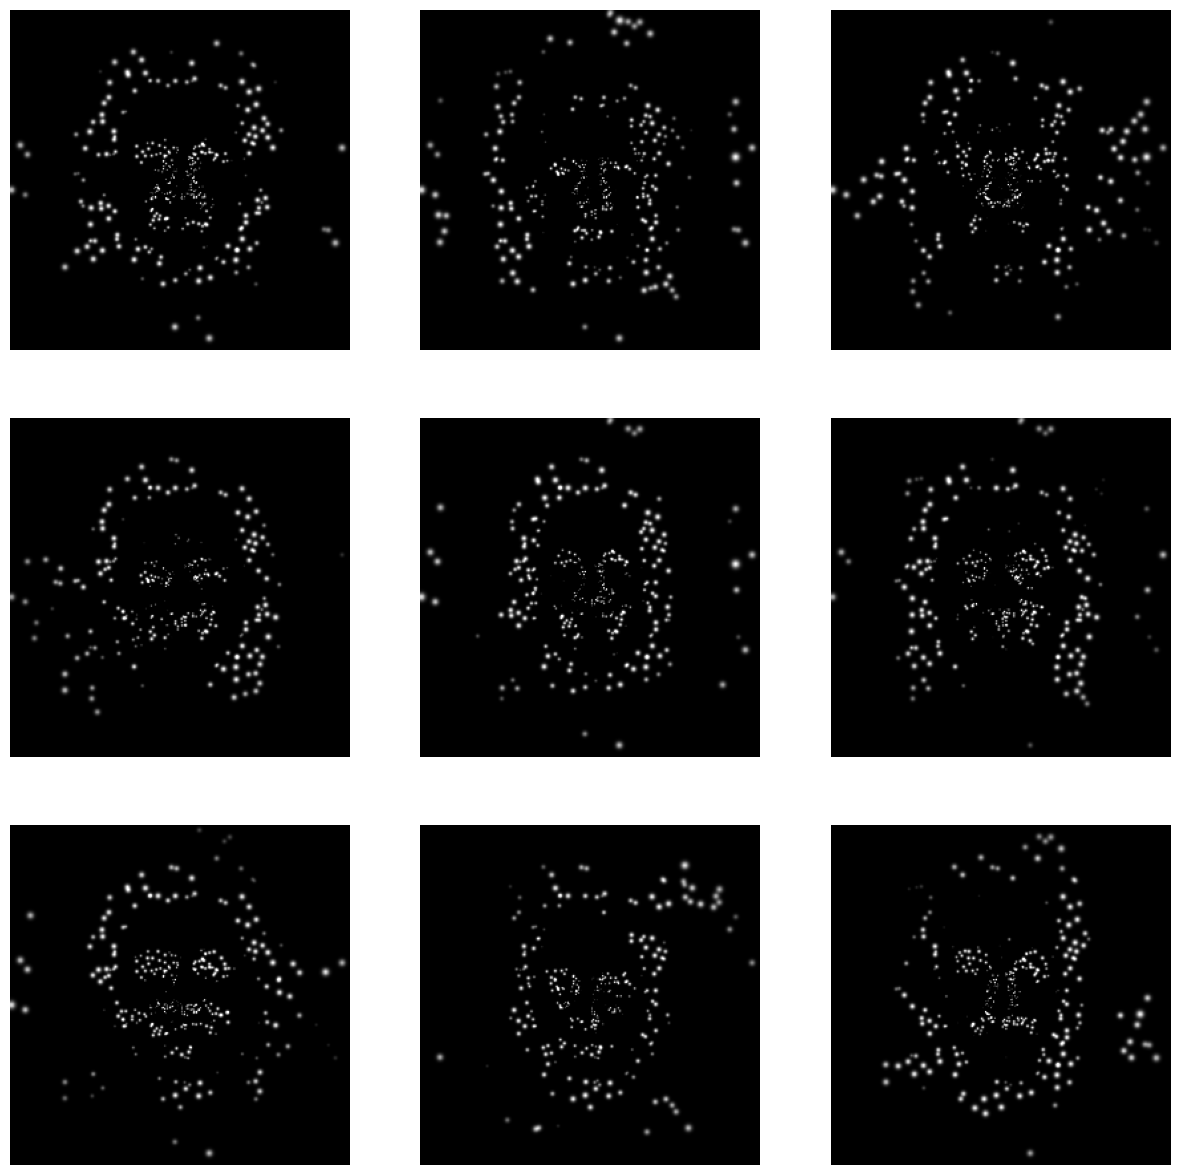

In [82]:
# show the images through the phosphene simulator

phos_images = []
for img in filtered_images:
    simulator.reset()
    stim = simulator.sample_stimulus(img[0].max(0), rescale=True)
    stim = modified_cdf_normalization(stim, amplitude)
    phos_img = simulator(stim * stim_weights)
    phos_images.append(phos_img)

# show phos_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(phos_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img.cpu(), cmap='gray')
    plt.axis('off')

plt.show()

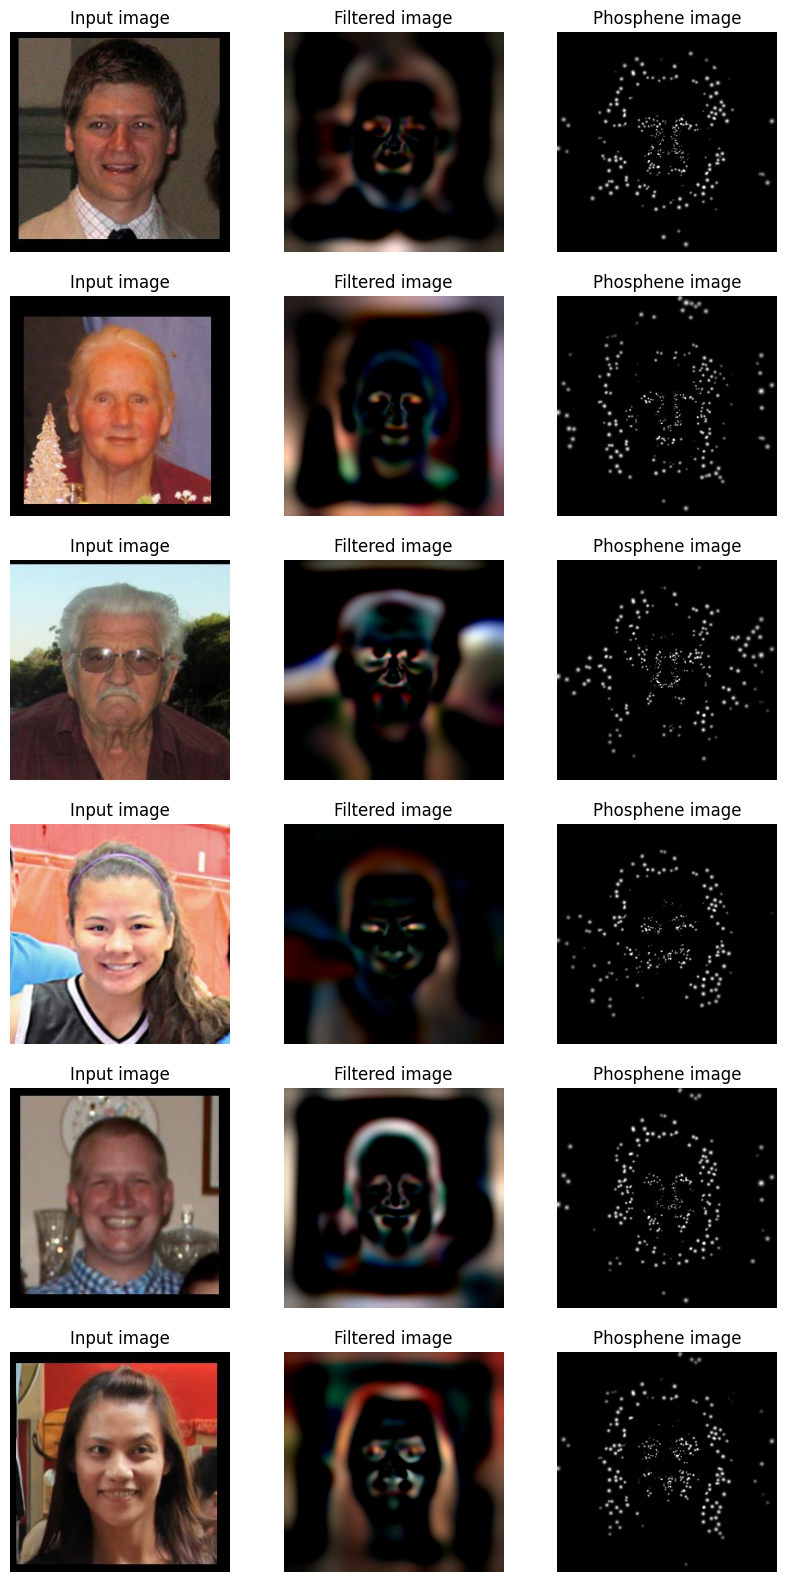

In [83]:
# show side by side:
# input image, filtered image and phosphene image

plt.figure(figsize=(10, 20))
imgs_to_show = 6

for i, (img, filtered_img, phos_img) in enumerate(zip(images, filtered_images, phos_images)):

    plt.subplot(imgs_to_show, 3, 3*i+1)
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Input image')

    plt.subplot(imgs_to_show, 3, 3*i+2)
    plt.imshow(filtered_img[0].transpose(1, 2, 0))
    plt.axis('off')
    plt.title('Filtered image')

    plt.subplot(imgs_to_show, 3, 3*i+3)
    plt.imshow(phos_img.cpu(), cmap='gray')
    plt.axis('off')
    plt.title('Phosphene image')

    if i == imgs_to_show - 1:
        break

## Gaussian Modulation

In [54]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_loader = DataLoader(
    ImageFolder('../../data/LaPa_zoomed/', transform=transform),
    batch_size=1,
    shuffle=False
)

In [55]:
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation

In [85]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=99,
    kernel_type="gaussian",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

UnifiedInputModulation()

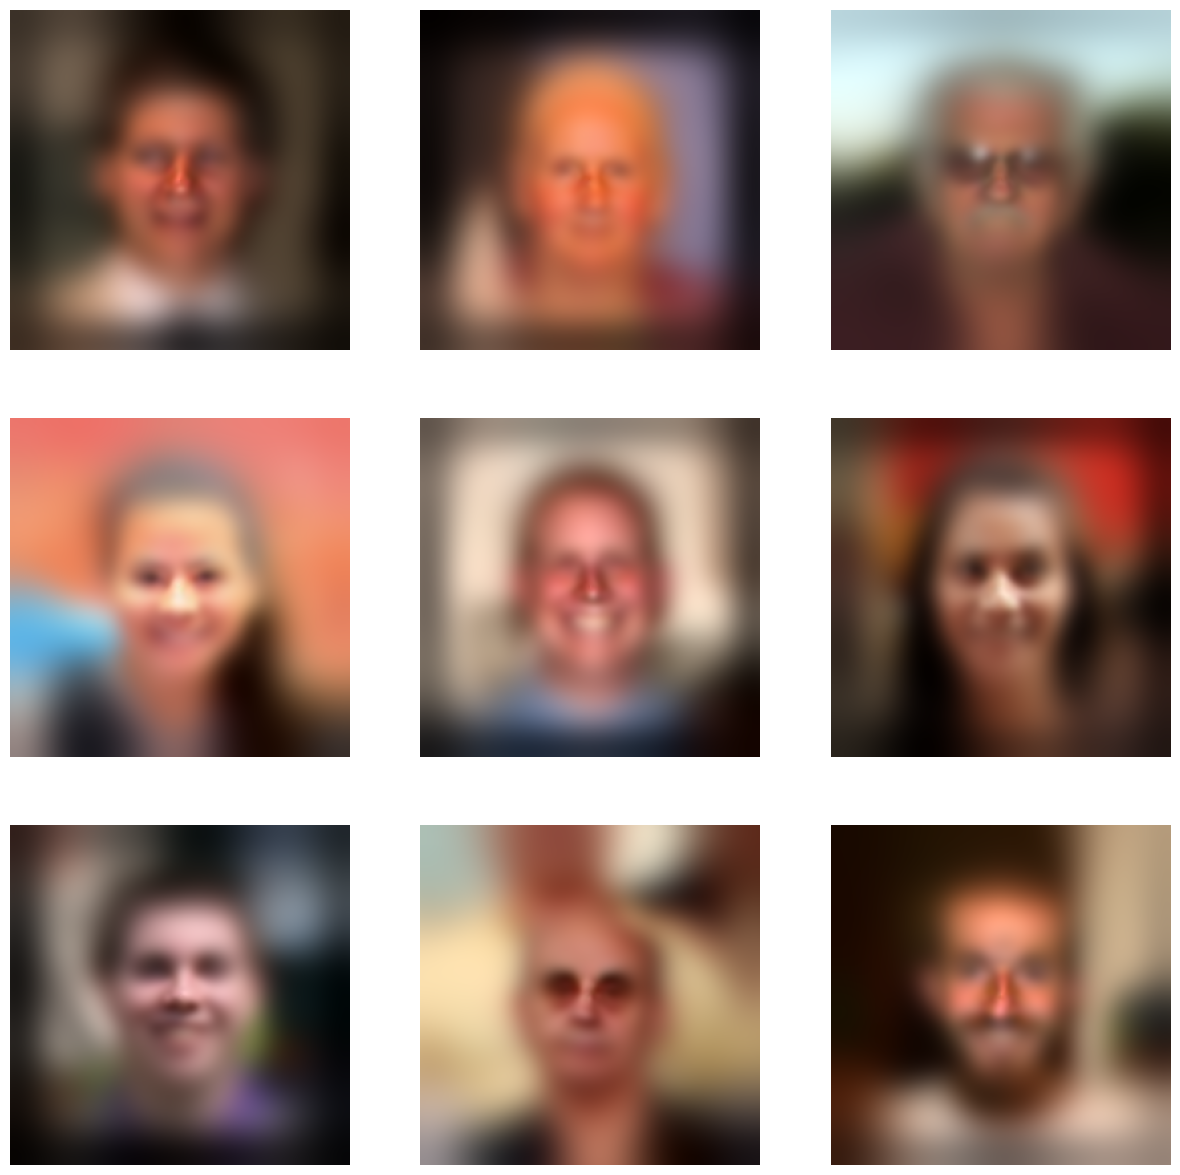

In [86]:
images = []
filtered_images = []

for img, _ in data_loader:
    img = img.cuda().detach()

    with torch.no_grad():
        filtered_img = layer(img).detach().cpu().clip(0, None).numpy()

    # normalize between 0 and 1
    filtered_img = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min())
    
    filtered_images.append(filtered_img)
    images.append(img.cpu())

    # show filtered_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(filtered_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0].transpose(1,2,0), cmap='gray')
    plt.axis('off')

plt.show()

# The Conv2D Layer

In [87]:
from spatial_frequency.components.modulated_conv2d import ModulatedConv2d
import torchvision.utils as vutils

In [88]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = ModulatedConv2d(
    in_channels=3,
    out_channels=9,
    kernel_size=5,
    modulation_kernel_size=99,
    kernel_type="gaussian",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()

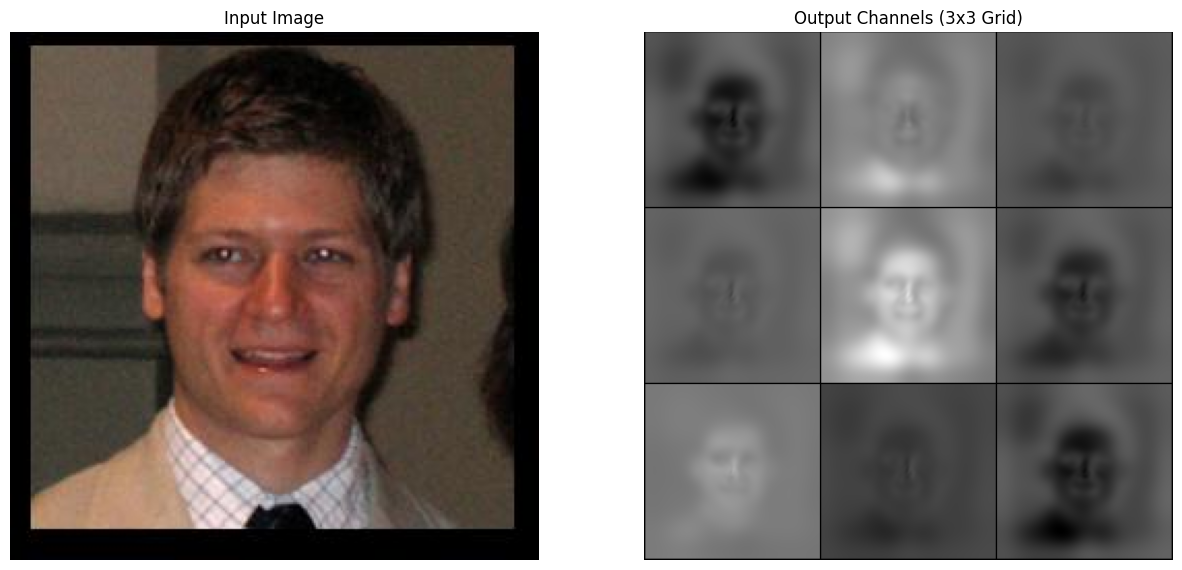

In [89]:
# Assume 'images' is your batch of input images and 'layer' is your model.
img = images[0].cuda().detach()  # shape: [B, C, H, W]
out = layer(img)                 # out: [B, 9, H, W]

# Display the input image.
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img[0].cpu().detach().permute(1, 2, 0))
plt.axis('off')
plt.title('Input Image')

# For the output, convert the 9 channels into 9 single-channel images.
# out[0] currently has shape [9, H, W]. Unsqueeze a channel dimension to get [9, 1, H, W].
out_channels = out[0].unsqueeze(1)  # shape becomes [9, 1, H, W]

# Create a 3x3 grid of these 9 images.
grid = vutils.make_grid(out_channels, nrow=3, normalize=True)
# grid has shape [1, H_grid, W_grid]; squeeze to get [H_grid, W_grid].
grid_img = grid.squeeze(0).cpu().numpy()

plt.subplot(1, 2, 2)
plt.imshow(grid_img.transpose(1,2,0), cmap='gray')
plt.axis('off')
plt.title('Output Channels (3x3 Grid)')

plt.show()